# Generalized MLM distribution simulation

In [1]:
library(evd)
library(maxstablePCA)
library(ggplot2)
library(dplyr)
library(GGally)
library(graphicalExtremes)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



### setup parameters and simulate data

In [2]:
set.seed(1234)
s <- 100

In [3]:
Z <- rmvevd(10000, dep = .8, model = "log", d = 3, mar = c(1,1,1))

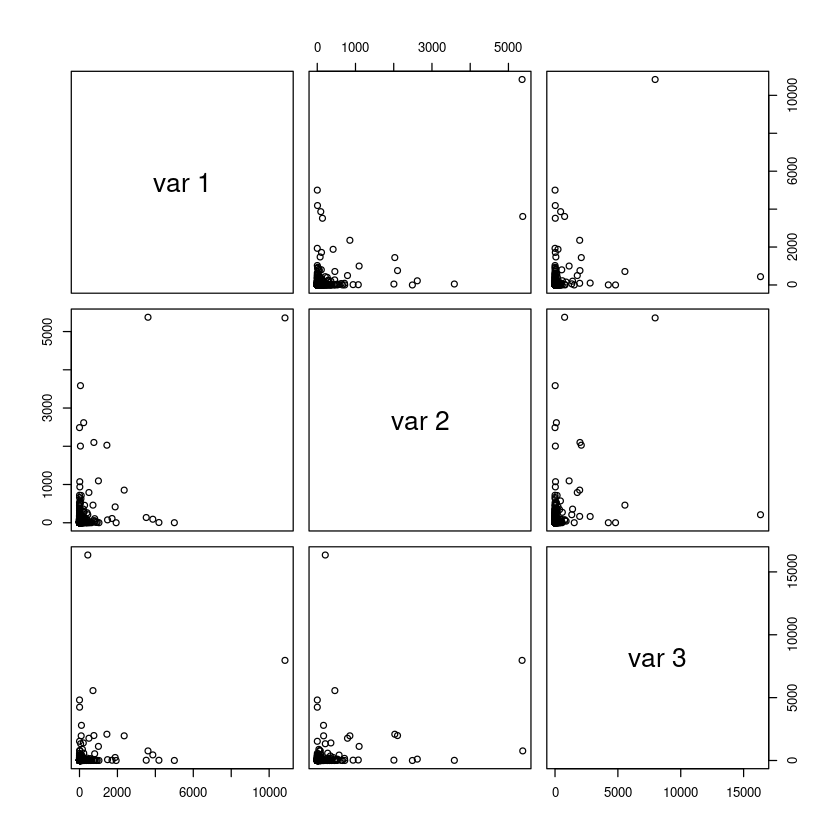

In [4]:
pairs(Z)

In [5]:
A <- matrix(NA, 6, 3)
A[1:3, ] <- diag(3)
A[4:6, ] <- matrix(
    c(0.3, 0.55, 0.15, 
     0.65, 0, 0.35, 
     0.3, 0.2, 0.5), 
    byrow = T, 3, 3)

In [6]:
A

1.00,0.00,0.00
0.00,1.00,0.00
0.00,0.00,1.00
0.30,0.55,0.15
0.65,0.00,0.35
0.30,0.20,0.50


In [7]:
X <- t(maxmatmul(A, t(Z)))
Xtrafo <- transform_unitpareto(X)

# max-stable PCA for X

In [8]:
summary(rowSums(Xtrafo))

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
    6.03     9.48    14.27    58.73    27.21 45000.00 

In [9]:
length(which(apply(Xtrafo, 1, max) > s))

[1] 239

In [10]:
maxPCA1 <- max_stable_prcomp(Xtrafo, p = 1, s = s, n_initial_guesses = 15000, norm = "linfty")
maxPCA2 <- max_stable_prcomp(Xtrafo, p = 2, s = s, n_initial_guesses = 15000, norm = "linfty")
maxPCA3 <- max_stable_prcomp(Xtrafo, p = 3, s = s, n_initial_guesses = 15000, norm = "linfty")
maxPCA4 <- max_stable_prcomp(Xtrafo, p = 4, s = s, n_initial_guesses = 15000, norm = "linfty")

### inspect relevant output 

In [11]:
maxPCA3

$p
[1] 3

$d
[1] 6

$decoder_matrix
            [,1]        [,2]        [,3]
[1,] 0.002060776 1.272131632 0.001524808
[2,] 0.003330380 0.002666272 1.715195833
[3,] 1.517151726 0.001438551 0.003033868
[4,] 0.271493726 0.506949183 1.064291296
[5,] 0.596527105 0.961742859 0.001410403
[6,] 0.858422269 0.528032278 0.464765683

$encoder_matrix
             [,1]         [,2]         [,3]        [,4]         [,5]
[1,] 0.0013023338 0.0007286359 0.6591404624 0.001504753 0.0018837392
[2,] 0.7861027623 0.0013369352 0.0009348598 0.001680694 0.0025655451
[3,] 0.0006582891 0.5830225745 0.0011135663 0.002785983 0.0009061474
            [,6]
[1,] 0.003893193
[2,] 0.001302235
[3,] 0.001615230

$reconstr_matrix
            [,1]        [,2]        [,3]        [,4]        [,5]        [,6]
[1,] 1.000026190 0.001700758 0.001358341 0.002138064 0.003263711 0.001656614
[2,] 0.002095964 0.999997891 0.002195188 0.004778506 0.001554220 0.002770435
[3,] 0.001975838 0.001768814 1.000016090 0.002282939 0.002857918 0.

In [12]:
maxPCA3$optim_conv_status

[1] 4

### report rounded estimated matrices

In [13]:
round(maxPCA3$decoder_matrix, 2)

0.00,1.27,0.00
0.00,0.00,1.72
1.52,0.00,0.00
0.27,0.51,1.06
0.60,0.96,0.00
0.86,0.53,0.46


In [14]:
round(maxPCA3$encoder_matrix, 2)

0.00,0.00,0.66,0,0,0
0.79,0.00,0.00,0,0,0
0.00,0.58,0.00,0,0,0


In [15]:
round(maxPCA3$reconstr_matrix, 2)

1.00,0.00,0.00,0,0,0.00
0.00,1.00,0.00,0,0,0.00
0.00,0.00,1.00,0,0,0.01
0.40,0.62,0.18,0,0,0.00
0.76,0.00,0.39,0,0,0.00
0.42,0.27,0.57,0,0,0.00


# Elbow plot for reconstruction error 

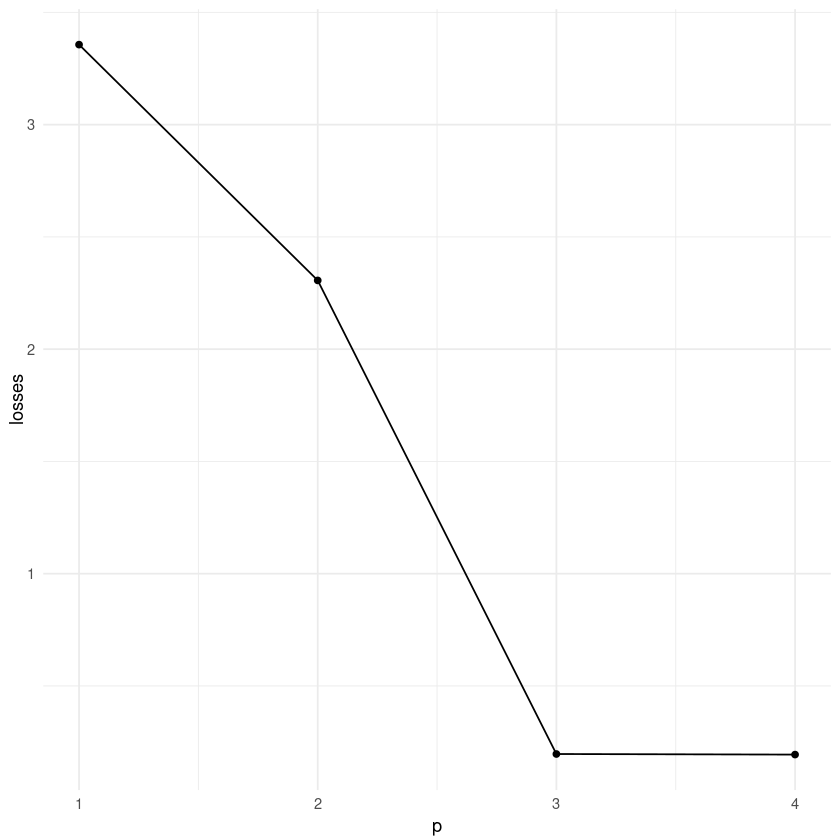

In [16]:
plotdat <- data.frame(p = 1:4, losses = c(
    maxPCA1$loss_fctn_value,
    maxPCA2$loss_fctn_value,
    maxPCA3$loss_fctn_value,
    maxPCA4$loss_fctn_value   
))

pe <- ggplot(aes(x = p, y = losses), data = plotdat) + geom_line() + geom_point() + theme_minimal()
pe

In [17]:
ggsave("genmlm_elbow.pdf", pe)

Saving 6.67 x 6.67 in image


# pairplot to visually inspect reconstruction

In [18]:
datX <- data.frame(X)
rec <- t(maxmatmul(maxPCA3$reconstr_matrix, t(as.matrix(datX))))
datX$is_rec = "original"
datrec <- data.frame(rec)
datrec$is_rec = "reconstruction"
names(datrec) <- names(datX)
plot_datX <- full_join(datX, datrec)

Joining with `by = join_by(X1, X2, X3, X4, X5, X6, is_rec)`


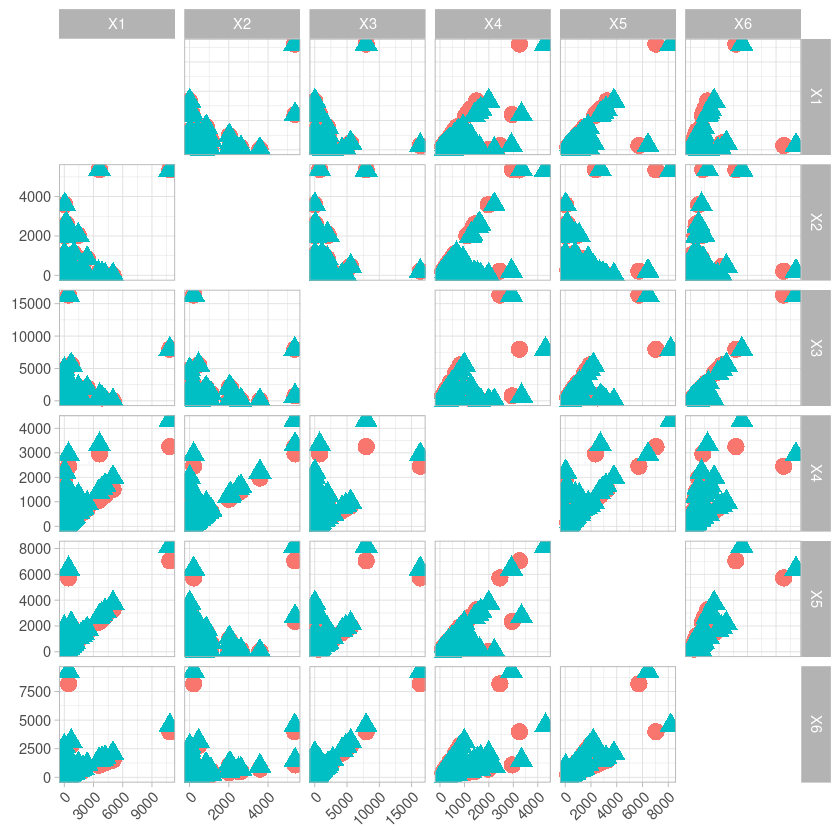

In [19]:
p <- ggpairs(
    plot_datX, 
    aes(color = is_rec, shape = is_rec, size = 2),
    columns = 1:6,
    upper = list(continuous = "points", combo = "dot_no_facet"),
    diag = list(continuous = "blankDiag", discrete = "barDiag", na = "naDiag")
) + 
theme_light() +
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

p

In [20]:
ggsave("genmlm.png", p)

Saving 6.67 x 6.67 in image


# Comparison to other methodologies 

In [21]:
Xsphere1 <- t(apply(Xtrafo, 1, function(z) z / max(z)))
Xsphere1 <- Xsphere1[which(apply(Xtrafo, 1, max) > s), ]

In [22]:
specdecomp1 <- eigen(t(Xsphere1) %*% Xsphere1 / 40)
specdecomp1

eigen() decomposition
$values
[1] 6.80015543 2.10032828 1.70212506 0.08844353 0.01731587 0.01241533

$vectors
           [,1]        [,2]       [,3]       [,4]       [,5]        [,6]
[1,] -0.4628161 -0.42370712  0.5025990 -0.4218845  0.2635369  0.32592872
[2,] -0.3589252  0.78028665  0.1639417 -0.3175643  0.1907473 -0.31339584
[3,] -0.4023525 -0.07123975 -0.7939804 -0.3890102 -0.1449342  0.17406237
[4,] -0.3730634  0.29998515  0.1817018  0.4004899 -0.5397581  0.53487019
[5,] -0.4344991 -0.33771124  0.1086703  0.1407899 -0.4320610 -0.69199273
[6,] -0.4088040 -0.05009934 -0.2128091  0.6241983  0.6286035 -0.01776928


In [23]:
rec1 <- X %*% specdecomp1$vectors[1:6, 1:2] %*% t(specdecomp1$vectors[1:6, 1:2])

plotdat_DS1 <- data.frame(X)
tmp <- data.frame(rec1)
plotdat_DS1 <- full_join(plotdat_DS1, tmp)
plotdat_DS1$is_rec <- c(rep(F, 10000), rep(T, 10000))

Joining with `by = join_by(X1, X2, X3, X4, X5, X6)`


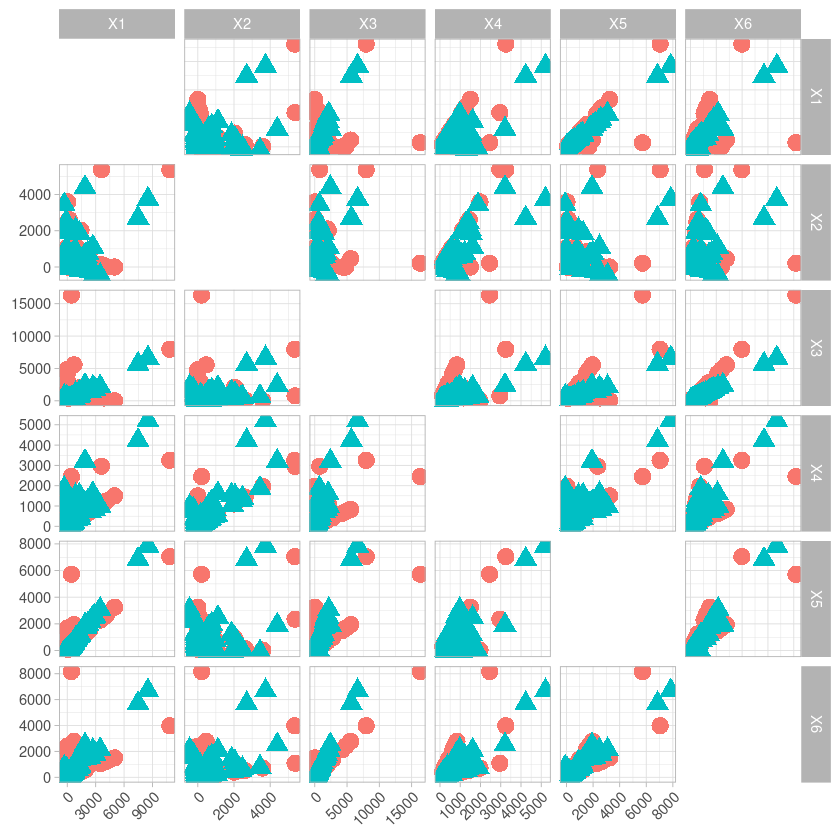

In [24]:
p <- ggpairs(
    plotdat_DS1, 
    aes(color = is_rec, shape = is_rec, size = 2),
    columns = 1:6,
    upper = list(continuous = "points", combo = "dot_no_facet"),
    diag = list(continuous = "blankDiag", discrete = "barDiag", na = "naDiag")
) + 
theme_light() +
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

p

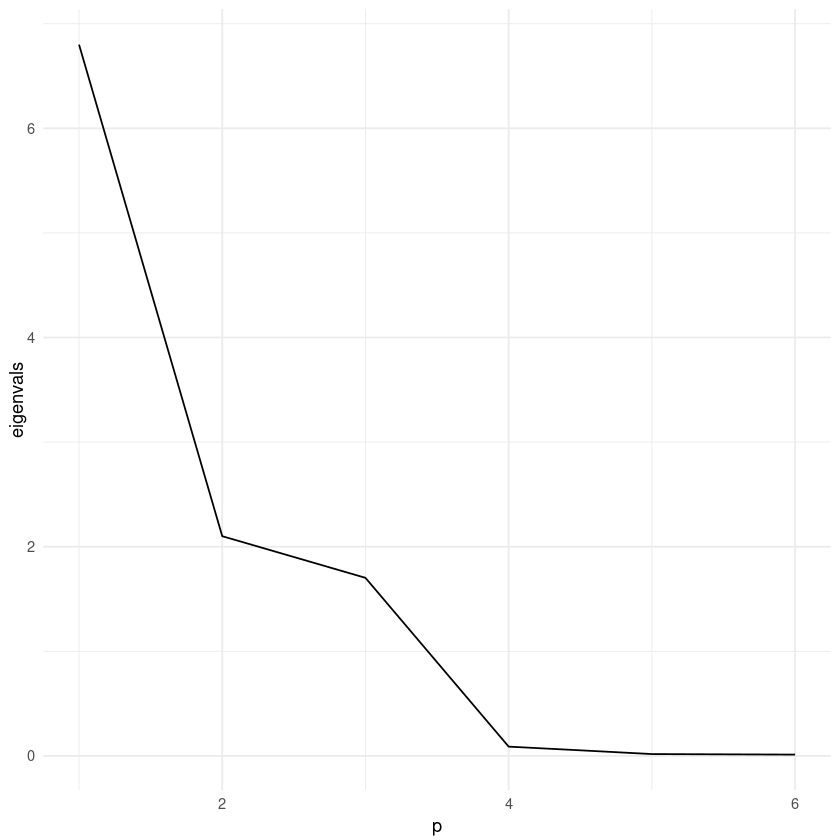

In [25]:
screeplotdat <- data.frame(p = 1:6, eigenvals = specdecomp1$values)

ggplot(aes(x = p, y = eigenvals), data = screeplotdat) + 
geom_line() + 
theme_minimal()

# Spherical K-means

In [26]:
library(skmeans)

In [27]:
kmeanserrs = data.frame(k = 1:6, errs = NA)
kmeansclusterings = list()
for(k in 2:6) {
    tmp <- skmeans::skmeans(X[which(rowSums(X) > 250), ], k = k)
    kmeansclusterings[[k]] <- tmp
    kmeanserrs[k,2] <- tmp$value
}

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_line()`).”


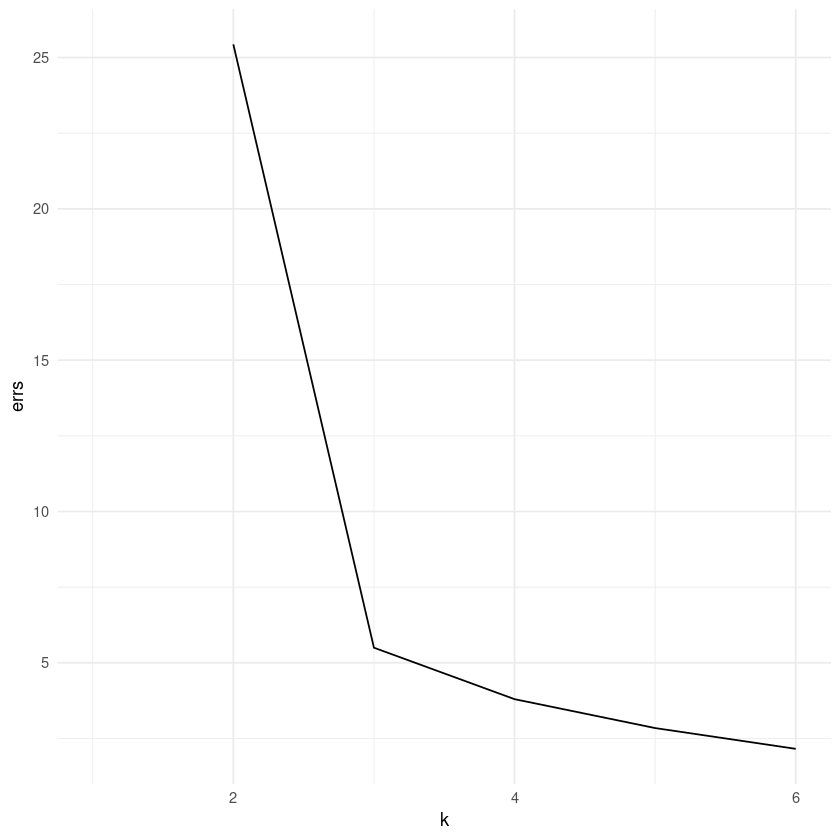

In [28]:
ggplot(aes(x = k, y = errs), data = kmeanserrs) + 
geom_line() +
theme_minimal()

### Cooley PCA

In [29]:
# Tail pairwise dependence matrix code by Yiang 

decls <- function(x, th, k) {
    ## Ordinary decluster.
    id.big <- which(x > th)
    id.dif <- diff(id.big)
    tick <- which(id.dif >= k)
    start <- id.big[c(1, tick + 1)]              # Where a new cluster begins
    end <- c(id.big[tick], last(id.big, 1))
    n <- length(start)
    id.res <- rep(0, n)
    for ( i in 1 : n) {
        temp <- x[start[i] : end[i]]
        id.res[i] <- which(temp == max(temp, na.rm = TRUE))[1] + start[i] - 1
    }
    id.res
}

rw.Sigma <- function(X, u = 0.98, decluster = F) {
    ## Compute TPDM
    P <- ncol(X)                      # Number of stations
    M <- nrow(X)                      # Number of obs
    Sigma <- matrix(0, P, P)
    for ( i in 1 : P) {
        if (i %% 5 == 0) print(i)
        for ( j in 1 : P) {
            r <- sqrt(X[, i] ^ 2 + X[, j] ^ 2)
            w1 <- X[, i] / r
            w2 <- X[, j] / r
            th <- quantile(r, u, na.rm = TRUE)
            if(decluster) {
                id <- decls(r, th, 5)
            } else {
                id <- which(r > th)
            } 
            Sigma[i, j] <- sum(w1[id] * w2[id], na.rm = TRUE) / (length(id)) * 2
        }
    }
    Sigma
}

ecdf_shifted <- function(z) length(z) / (length(z) + 1) * ecdf(z)(z) + 1 / (length(z) + 1)

In [30]:
# Transform data to approximately 2-Fréchet margins 
Xtrafo_2frech <- apply(Xtrafo, 2, function(z) sqrt(-log(ecdf_shifted(z))))

In [31]:
tpdm <- rw.Sigma(Xtrafo_2frech)
# tpdm <- nearPD(tpdm)$mat

[1] 5


In [32]:
specdecomp_cy <- eigen(tpdm)

In [33]:
specdecomp_cy

eigen() decomposition
$values
[1]  5.6334079970  0.1899851393  0.1349803605  0.0306990281  0.0114729968
[6] -0.0005455218

$vectors
           [,1]       [,2]        [,3]       [,4]        [,5]       [,6]
[1,] -0.4048412 -0.2409718  0.65685660 -0.4571274  0.30171942  0.2158137
[2,] -0.3981227  0.7299614 -0.09264368 -0.3919792 -0.07499218 -0.3752338
[3,] -0.4033971 -0.3232406 -0.66244396 -0.3588707 -0.16623854  0.3708516
[4,] -0.4131473  0.3730471  0.14143757  0.5474627 -0.15572903  0.5883652
[5,] -0.4130875 -0.3808886  0.20016820  0.2309796 -0.60657253 -0.4721584
[6,] -0.4165822 -0.1427033 -0.24708836  0.3943751  0.69535930 -0.3255550


Saving 6.67 x 6.67 in image


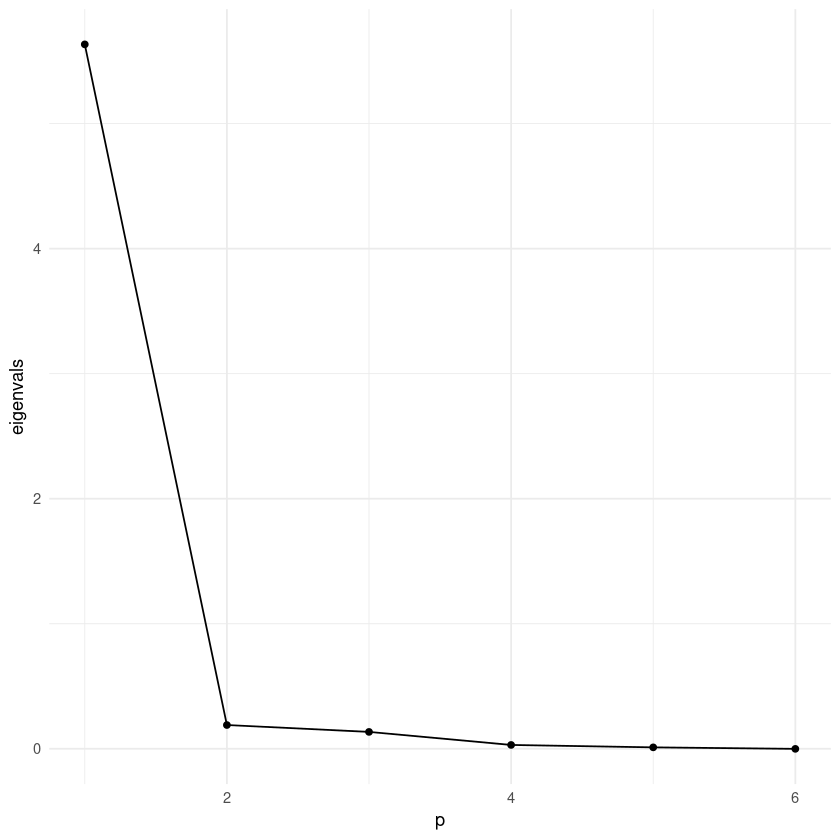

In [34]:
elbow_dat_cy <- data.frame(p = 1:6, eigenvals = specdecomp_cy$values)
elbow_cy <- ggplot(aes(x = p, y = eigenvals), data = elbow_dat_cy) +
geom_line() + 
geom_point () + 
theme_minimal()

ggsave("elbow_epca_cy_genmlm.pdf", elbow_cy)
elbow_cy